In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import sklearn
from scipy.stats import norm

# Do not show warnings
import warnings
warnings.filterwarnings('ignore')

# Missing Values Imputation libraries
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import KNNImputer

# Import Matplotlib for visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot
from matplotlib import style
plt.style.use('ggplot')
import seaborn as sns
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 10, 7

# Feature Selection/ Extraction libraries
from sklearn.linear_model import LassoCV

# Model Development libraries
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, roc_curve

pd.options.display.float_format = '{:.6f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
events = pd.read_csv('/content/drive/MyDrive/Data Science Case Study - Candidate Download Folder/data_events.csv')
retention = pd.read_csv('/content/drive/MyDrive/Data Science Case Study - Candidate Download Folder/data_retention.csv')

In [4]:
events.head()

,user_pseudo_id,event_name,event_count
0,b77c070ea6bebab1b35869f2cea470bb,item_saved,58
1,48CA2D5DCC1B42F58C0C1CC0C82B3889,user_unfollowed,41
2,6d020ffe06aec17532a4ea558e370b8e,outfit_sent,59
3,FEF2FC6721994A659FA570B334FC2425,user_items_uploaded,46
4,693230A8ABE64D3A808F908A537E2985,sticker_uploaded,19


In [5]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   user_pseudo_id  500000 non-null  object
 1   event_name      500000 non-null  object
 2   event_count     500000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 11.4+ MB


In [6]:
retention.head()

,user_pseudo_id,retentionScore
0,b77c070ea6bebab1b35869f2cea470bb,2.124394
1,48CA2D5DCC1B42F58C0C1CC0C82B3889,0.193921
2,6d020ffe06aec17532a4ea558e370b8e,0.004651
3,FEF2FC6721994A659FA570B334FC2425,0.138679
4,693230A8ABE64D3A808F908A537E2985,0.103337


In [7]:
retention.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373296 entries, 0 to 373295
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_pseudo_id  373296 non-null  object 
 1   retentionScore  373296 non-null  float64
dtypes: float64(1), object(1)
memory usage: 5.7+ MB


#### **Data Preparation**

In [8]:
df001 = events.groupby(['user_pseudo_id', 'event_name']).event_count.sum().to_frame()
df002 = df001.reset_index().pivot('user_pseudo_id', 'event_name')['event_count']

In [9]:
df002 = df002.reset_index()

In [10]:
 columns =   ['add_sticker_tapped', 'app_clear_data', 'app_exception', 'app_remove', 'app_update', 'challenge_created',
                          'challenge_shared', 'comment_liked', 'comment_posted', 'create_new_collection_tapped', 'draft_saved',
                          'feed_invite_friends_tapped', 'fiam_action', 'fiam_dismiss', 'firebase_in_app_message_action', 'firebase_in_app_message_dismiss',
                          'firebase_in_app_message_impression', 'first_open', 'hashtag_selected', 'help_video_selected', 'invite_friends_shared', 'item_added',
                          'item_collection_created', 'item_collection_tooltip_tapped', 'item_removed', 'item_saved', 'notification_foreground',
                          'notification_open', 'os_update', 'outfit_collections_tooltip_tapped', 'outfit_liked', 'outfit_saved', 'outfit_sent', 'outfit_unliked',
                          'quick_add_recently_added', 'quick_add_saved_items', 'quick_add_uploaded_user_items', 'save_outfit_tooltip_tapped',
                          'saved_outfit_challenge_option_selected', 'saved_outfit_edited', 'saved_outfit_opened', 'saved_outfit_option_selected', 'screen_view',
                          'search_input_tapped', 'search_tab_selected', 'sticker_image_cut', 'sticker_image_selected', 'sticker_uploaded', 'user_blocked',
                          'user_items_uploaded', 'user_unblocked', 'user_unfollowed']

In [11]:
cols = df002[columns].replace(np.nan, 0)
cols_int = cols.astype(int)

In [12]:
df003 = pd.concat([df002['user_pseudo_id'], cols_int], axis = 1)

Concatenate the df003 dataset with the retention dataframe

In [13]:
retention['user_pseudo_id1'] = retention['user_pseudo_id'] 

In [14]:
df004 = pd.merge(df003, retention, left_on='user_pseudo_id', right_on='user_pseudo_id1', how='left')

In [15]:
df004 = df004.drop(columns = ['user_pseudo_id_x', 'user_pseudo_id_y'], axis = 1)

#df004['user_pseudo_id'] = df004['user_pseudo_id_x']

In [16]:
cols = list(df004.columns)
cols = [cols[-1]] + cols[:-1]
df004 = df004[cols]

In [17]:
df004.head()

,user_pseudo_id1,add_sticker_tapped,app_clear_data,app_exception,app_remove,app_update,challenge_created,challenge_shared,comment_liked,comment_posted,create_new_collection_tapped,draft_saved,feed_invite_friends_tapped,fiam_action,fiam_dismiss,firebase_in_app_message_action,firebase_in_app_message_dismiss,firebase_in_app_message_impression,first_open,hashtag_selected,help_video_selected,invite_friends_shared,item_added,item_collection_created,item_collection_tooltip_tapped,item_removed,item_saved,notification_foreground,notification_open,os_update,outfit_collections_tooltip_tapped,outfit_liked,outfit_saved,outfit_sent,outfit_unliked,quick_add_recently_added,quick_add_saved_items,quick_add_uploaded_user_items,save_outfit_tooltip_tapped,saved_outfit_challenge_option_selected,saved_outfit_edited,saved_outfit_opened,saved_outfit_option_selected,screen_view,search_input_tapped,search_tab_selected,sticker_image_cut,sticker_image_selected,sticker_uploaded,user_blocked,user_items_uploaded,user_unblocked,user_unfollowed,retentionScore
0,00009AF4B8034D85BA73FBB50449EB03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0.100652
1,0000FDFB612048C4ADE183048E60F96A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.057352
2,0000bbe16768495e99af97b01af56e58,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0.075264
3,0000eae55d00705b96f4873e20d0d0b8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0.111569
4,0000f3f2f1f426945d0fc33243468c1c,0,0,0,0,0,2,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.118126


In [18]:
perc = [0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
df004['retentionScore'].describe(percentiles = perc)

count   373296.000000
mean        20.811345
std        129.201148
min          0.001000
50%          0.133441
75%          0.199550
80%          2.007206
85%          6.165019
90%         24.025629
95%         93.059195
99%        451.022170
max      20526.061321
Name: retentionScore, dtype: float64

We can see that the Retention Score column has a  lot of outliers. 

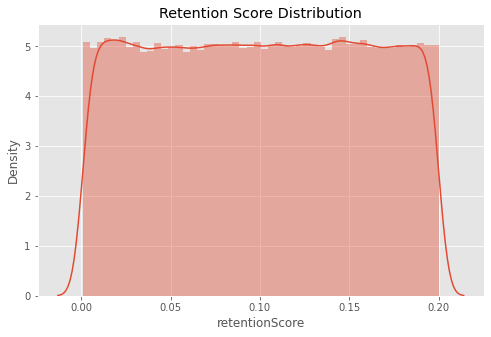

In [19]:
plt.figure(figsize = (8, 5))
plt.title('Retention Score Distribution')
sns.distplot(df004.query('retentionScore < 1')['retentionScore'])

I have replaced the outlier values (scores > 1) with NaN. I shall use the KNN Imputer to impute the missing values. The logic around using KNNImputer is that it uses the Euclidean distance of two points to compare records across variables. It identifies the neighboring points through a measure of similarity and the missing values can be estimated using completed values of similar records.

In [20]:
df004.loc[df004['retentionScore'] > 1, 'retentionScore'] = np.nan

In [21]:
user_pseudo_id = df004['user_pseudo_id1']
df004 = df004.drop(['user_pseudo_id1'], axis = 1)

In [22]:
imputer = KNNImputer(n_neighbors = 1, weights = 'distance', metric = 'nan_euclidean')
df005 = imputer.fit_transform(df004)

In [23]:
df006 = pd.DataFrame(data = df005[:, :], columns = df004.columns)
df006.head()

,add_sticker_tapped,app_clear_data,app_exception,app_remove,app_update,challenge_created,challenge_shared,comment_liked,comment_posted,create_new_collection_tapped,draft_saved,feed_invite_friends_tapped,fiam_action,fiam_dismiss,firebase_in_app_message_action,firebase_in_app_message_dismiss,firebase_in_app_message_impression,first_open,hashtag_selected,help_video_selected,invite_friends_shared,item_added,item_collection_created,item_collection_tooltip_tapped,item_removed,item_saved,notification_foreground,notification_open,os_update,outfit_collections_tooltip_tapped,outfit_liked,outfit_saved,outfit_sent,outfit_unliked,quick_add_recently_added,quick_add_saved_items,quick_add_uploaded_user_items,save_outfit_tooltip_tapped,saved_outfit_challenge_option_selected,saved_outfit_edited,saved_outfit_opened,saved_outfit_option_selected,screen_view,search_input_tapped,search_tab_selected,sticker_image_cut,sticker_image_selected,sticker_uploaded,user_blocked,user_items_uploaded,user_unblocked,user_unfollowed,retentionScore
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100652
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.158661
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.075264
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.111569
4,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.138947


In [24]:
df006[columns] =  df006[columns].astype(int)

I shall now create the churn column. Which details whether or not a user has a probability to churn.  To do  this, I shall set  a threshold value at 0.1. A value lower than 0.1 is considered low and hence would churn where as a value higher than 0.1 would not churn. 
Therefore The churn label would have 
- 0 =>> Not churn
- 1 =>> Churn

In [25]:
df006['churn'] = np.where(df006['retentionScore'] >= 0.1, 0, 1)

In [26]:
churn = df006['churn']
df007 = df006.drop('churn', axis = 1)
columns = df007.columns

# **Feature Selection**

Best alpha using built-in LassoCV: 0.004659
Best score using built-in LassoCV: 0.006142
Lasso picked 10 variables and eliminated the other 42 variables


Text(0.5, 1.0, 'Feature Importance using Lasso Model')

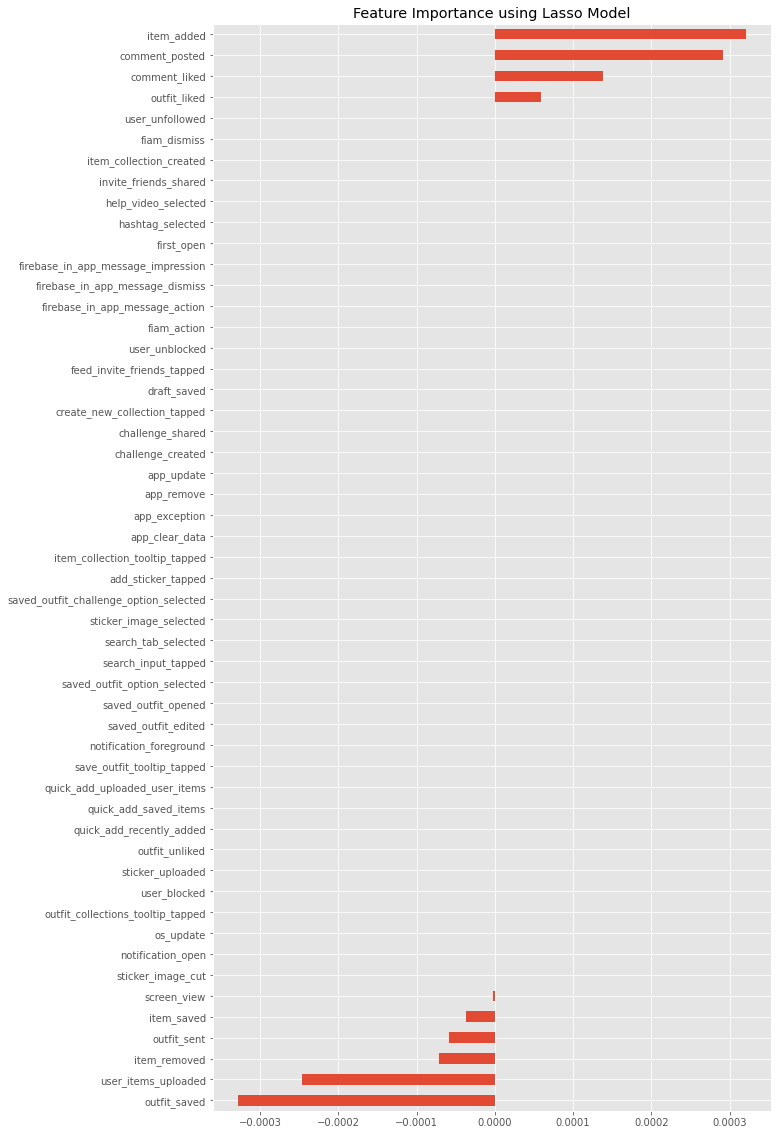

In [32]:
y = churn
X = df007.drop('retentionScore', axis = 1)

reg = LassoCV()
reg.fit(X, y)
print('Best alpha using built-in LassoCV: %f' % reg.alpha_)
print('Best score using built-in LassoCV: %f' %reg.score(X, y))
coef = pd.Series(reg.coef_, index = X.columns)

print('Lasso picked ' + str(sum(coef != 0)) + ' variables and eliminated the other ' + str(sum(coef == 0)) + ' variables')

imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (10, 20)
imp_coef.plot(kind = 'barh')
plt.title('Feature Importance using Lasso Model')

In [33]:
df008 = df007[['item_added', 'comment_posted', 'comment_liked', 'outfit_liked', 'screen_view', 'item_saved', 'outfit_sent', 'item_removed', 'user_items_uploaded', 'outfit_saved']]
df008 = pd.concat([df008, df007['retentionScore'], churn], axis = 1)

In [34]:
df008['churn'].value_counts()

1    192753
0    180543
Name: churn, dtype: int64

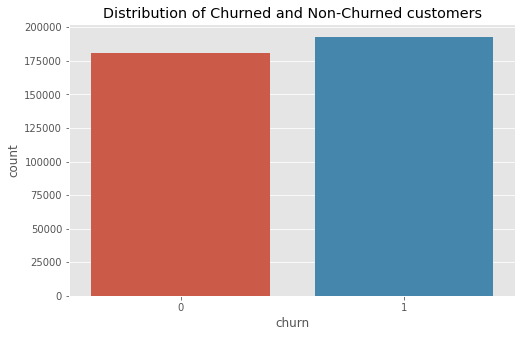

In [35]:
plt.figure(figsize = (8, 5))
plt.title('Distribution of Churned and Non-Churned customers')
sns.countplot(df008['churn'])

In [36]:
model = PCA(n_components = 6).fit(df007)
X_pc = model.transform(df007)

# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = df007.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
features = list(dic.items())

In [37]:
features

[('PC0', 'screen_view'),
 ('PC1', 'item_added'),
 ('PC2', 'item_removed'),
 ('PC3', 'outfit_liked'),
 ('PC4', 'item_saved'),
 ('PC5', 'comment_posted')]

# **Model Development**

In [38]:
new_columns = ['screen_view', 'item_added', 'item_removed', 'outfit_liked', 'item_saved', 
               'comment_posted']

In [39]:
data = pd.DataFrame(data = X_pc[:,:], columns = new_columns)

In [60]:
data.var()

screen_view      244597.017905
item_added        12433.100152
item_removed       2043.037700
outfit_liked       3946.416921
item_saved         1137.952605
comment_posted       97.604778
dtype: float64

In [40]:
target = churn

train_target = target.iloc[:253293]
test_target = target.iloc[253293:]

train_data = data.iloc[:253293]
test_data = data.iloc[253293:]

In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(train_data, train_target, test_size = 0.30, random_state = 42)


Part of a requirement for a standardised data set is to have each attribute have a mean value of zero and a standard deviation of 1. I shall implement standardisation using pipelines and then use cross-validation to validate performance of all the algorithms.

In [46]:
pipelines = []
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()), ('RF', RandomForestClassifier())])))
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression())])))
pipelines.append(('ScaledXGB', Pipeline([('Scaler', StandardScaler()), ('XGB', XGBClassifier())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits = 4, random_state = 42)
    cv_results = cross_val_score(model, X_train, Y_train, cv = kfold, scoring = 'neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    notification = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(notification)

ScaledKNN: -0.115998 (0.001372)
ScaledRF: -0.358383 (0.006625)
ScaledLR: -0.483686 (0.002440)
ScaledXGB: -0.281791 (0.018557)


From the output above, it looks like the Logistic Regression and Random Forest Algorithms perform best using a scaled version of the data. 

Either way, I shall choose the **Logistic Regression** and the **Random Forest Classifier**. 

### **Logistic Regression**

In [47]:
param_grid = {'C': np.array([0.01,0.1,1,10,100, 1000])}
logit = LogisticRegression(penalty = 'l1', solver = 'liblinear', random_state = 42)
kfold = KFold(n_splits = 4, random_state = 42)
grid = GridSearchCV(estimator = logit, param_grid = param_grid, scoring = 'neg_mean_squared_error', cv = kfold)
grid_result = grid.fit(X_train, Y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, stdev, param))

print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

-0.483703 (0.002488) with: {'C': 0.01}
-0.483652 (0.002494) with: {'C': 0.1}
-0.483703 (0.002443) with: {'C': 1.0}
-0.483686 (0.002440) with: {'C': 10.0}
-0.483686 (0.002440) with: {'C': 100.0}
-0.483686 (0.002440) with: {'C': 1000.0}
Best: -0.483652 using {'C': 0.1}


The best C parameter configuration is 0.1 with a negative mean square error closest to 0.

#### **Validate Model** - Logistic Regression

In [48]:
logit = LogisticRegression(C = 0.1, penalty = 'l1', solver = 'saga', random_state = 42)

logit.fit(X_train, Y_train)

X_test = abs(X_test)
predictions_logit = logit.predict(X_test)
probabilities_logit = logit.predict_proba(X_test)[:, 1]

**Model Evaluation**

In [49]:
print('Accuracy of Logistic Regression on training set: {:.6f}'.format(logit.score(X_train, Y_train)))
print('AUC Score of the Logistic Regression is: {:.6f}'.format(roc_auc_score(Y_test, probabilities_logit)))
target_names = ['Not-Churn', 'Churn']

# Classification Report for Logistic Regression
print(classification_report(Y_test, predictions_logit, target_names = target_names))

# Confusion Matrix for Logistic Regression
confusion_matrix_logit = pd.crosstab(Y_test, predictions_logit, rownames = ['Actual'], colnames = ['Predicted'])
print(confusion_matrix_logit)

Accuracy of Logistic Regression on training set: 0.533786
AUC Score of the Logistic Regression is: 0.513133
              precision    recall  f1-score   support

   Not-Churn       0.54      0.00      0.01     36708
       Churn       0.52      1.00      0.68     39280

    accuracy                           0.52     75988
   macro avg       0.53      0.50      0.34     75988
weighted avg       0.53      0.52      0.36     75988

Predicted    0      1
Actual               
0          160  36548
1          135  39145


##**Random Forest Classifier** 

In [50]:
param_grid = {'n_estimators': np.array([200, 400, 600]), 
              'max_depth': np.array([4, 7, 9])}
rfc = RandomForestClassifier(random_state = 42)
kfold = KFold(n_splits = 4, random_state = 42)
grid = GridSearchCV(estimator = rfc, param_grid = param_grid, scoring = 'roc_auc', cv = kfold)
grid_result = grid.fit(X_train, Y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, stdev, param))

print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

0.768297 (0.006095) with: {'max_depth': 4, 'n_estimators': 200}
0.769647 (0.006752) with: {'max_depth': 4, 'n_estimators': 400}
0.771263 (0.006625) with: {'max_depth': 4, 'n_estimators': 600}
0.871870 (0.002707) with: {'max_depth': 7, 'n_estimators': 200}
0.873654 (0.001369) with: {'max_depth': 7, 'n_estimators': 400}
0.873142 (0.001119) with: {'max_depth': 7, 'n_estimators': 600}
0.903659 (0.002522) with: {'max_depth': 9, 'n_estimators': 200}
0.904938 (0.001832) with: {'max_depth': 9, 'n_estimators': 400}
0.904911 (0.001966) with: {'max_depth': 9, 'n_estimators': 600}
Best: 0.904938 using {'max_depth': 9, 'n_estimators': 400}


#### **Validate Model** - Random Forest Classifier

In [51]:
rfc = RandomForestClassifier(n_estimators = 400 , max_depth = 9)

rfc.fit(X_train, Y_train)

X_test = abs(X_test)
predictions_rfc = rfc.predict(X_test)
probabilities_rfc = rfc.predict_proba(X_test)[:, 1]

#### **Model Evaluation**

In [52]:
print('Accuracy of Random Forest Classifier on training set: {:.6f}'.format(rfc.score(X_train, Y_train)))
print('AUC Score of the Random Forest Classifier is: {:.6f}'.format(roc_auc_score(Y_test, probabilities_rfc)))
target_names = ['Not-Churn', 'Churn']

# Classification Report for Random Forest Classifier
print(classification_report(Y_test, predictions_rfc, target_names = target_names))

# Confusion Matrix for Random Forest Classifier
confusion_matrix_rfc = pd.crosstab(Y_test, predictions_rfc, rownames = ['Actual'], colnames = ['Predicted'])
print(confusion_matrix_rfc)

Accuracy of Random Forest Classifier on training set: 0.805290
AUC Score of the Random Forest Classifier is: 0.496766
              precision    recall  f1-score   support

   Not-Churn       0.29      0.03      0.05     36708
       Churn       0.51      0.94      0.66     39280

    accuracy                           0.50     75988
   macro avg       0.40      0.48      0.35     75988
weighted avg       0.40      0.50      0.36     75988

Predicted     0      1
Actual                
0           956  35752
1          2355  36925


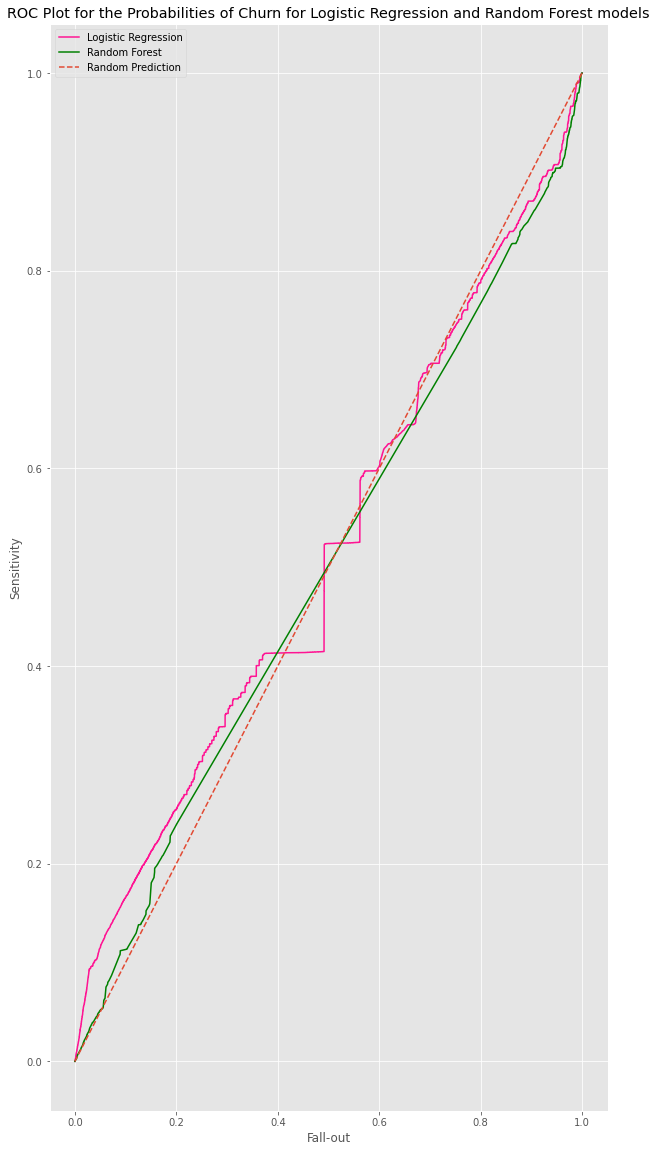

In [53]:
# ROC chart components
fallout_logit, sensitivity_logit, thresholds_logit = roc_curve(Y_test, probabilities_logit)
fallout_rfc, sensitivity_rfc, thresholds_rfc = roc_curve(Y_test, probabilities_rfc)

# ROC Chart with both Logistic Regresssion and Random Forest Classifier models
plt.plot(fallout_logit, sensitivity_logit, color = 'deeppink', label='%s' % 'Logistic Regression')
plt.plot(fallout_rfc, sensitivity_rfc, color = 'green', label='%s' % 'Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title('ROC Plot for the Probabilities of Churn for Logistic Regression and Random Forest models')
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

### **Model Implementation on Test data**

### Random Forest Classifier

In [55]:
rfc_model_final = RandomForestClassifier(max_depth = 9, n_estimators = 400, random_state = 42)

rfc_model_final.fit(X_train, np.ravel(Y_train))

data = abs(test_data)
actual = test_target
predictions_rfc_final = rfc_model_final.predict(data)
probabilities_rfc_final = rfc_model_final.predict_proba(data)[:, 1]

In [56]:
print('Accuracy of Random Forest Classifier on Final data: {:.6f}'.format(rfc_model_final.score(data, actual)))
print('AUC Score of the Random Forest Classifier is: {:.6f}'.format(roc_auc_score(actual, probabilities_rfc_final)))
target_names = ['Not-Churn', 'Churn']

# Classification Report for Random Forest Classifier
print(classification_report(actual, predictions_rfc_final, target_names = target_names))

# Confusion Matrix for Random Forest Classifier
confusion_matrix_final = pd.crosstab(actual, predictions_rfc_final, rownames = ['Actual'], colnames = ['Predicted'])
print(confusion_matrix_final)

Accuracy of Random Forest Classifier on Final data: 0.484638
AUC Score of the Random Forest Classifier is: 0.486206
              precision    recall  f1-score   support

   Not-Churn       0.31      0.05      0.09     58084
       Churn       0.50      0.89      0.64     61919

    accuracy                           0.48    120003
   macro avg       0.40      0.47      0.36    120003
weighted avg       0.41      0.48      0.37    120003

Predicted     0      1
Actual                
0          2946  55138
1          6707  55212


### Logistic Regression

In [57]:
logit_model_final = LogisticRegression(C = 0.1, penalty = 'l1', solver = 'saga', random_state = 42)

logit_model_final.fit(X_train, np.ravel(Y_train))

data = abs(test_data)
actual = test_target
predictions_logit_final = logit_model_final.predict(data)
probabilities_logit_final = logit_model_final.predict_proba(data)[:, 1]

In [58]:
print('Accuracy of Logistic Regression on Final data: {:.6f}'.format(logit_model_final.score(data, actual)))
print('AUC Score of the Logistic Regression is: {:.6f}'.format(roc_auc_score(actual, probabilities_logit_final)))
target_names = ['Not-Churn', 'Churn']

# Classification Report for Logistic Regression
print(classification_report(actual, predictions_logit_final, target_names = target_names))

# Confusion Matrix for Logistic Regression
confusion_matrix_final = pd.crosstab(actual, predictions_logit_final, rownames = ['Actual'], colnames = ['Predicted'])
print(confusion_matrix_final)

Accuracy of Logistic Regression on Final data: 0.516179
AUC Score of the Logistic Regression is: 0.512994
              precision    recall  f1-score   support

   Not-Churn       0.53      0.00      0.01     58084
       Churn       0.52      1.00      0.68     61919

    accuracy                           0.52    120003
   macro avg       0.52      0.50      0.34    120003
weighted avg       0.52      0.52      0.35    120003

Predicted    0      1
Actual               
0          243  57841
1          219  61700
